In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 5.55 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


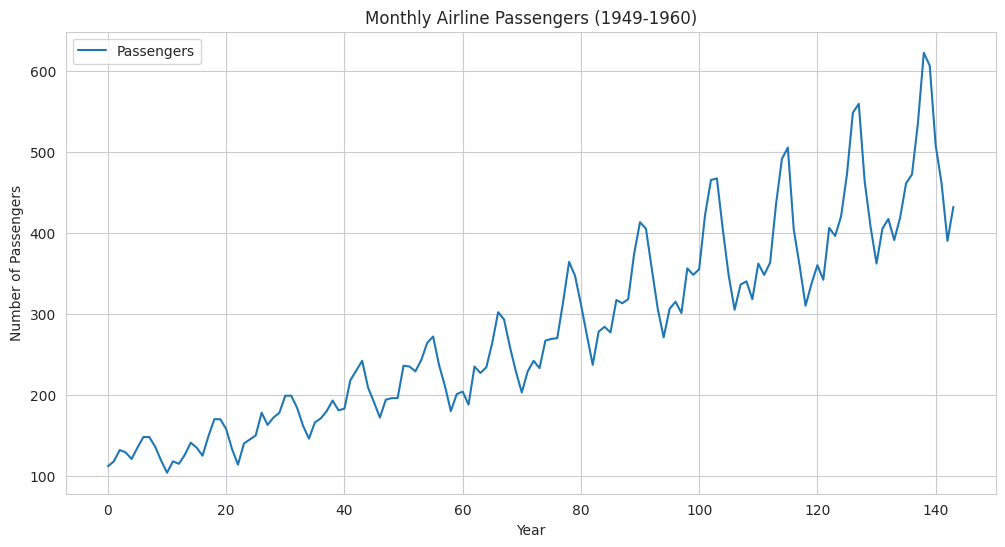

In [ ]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

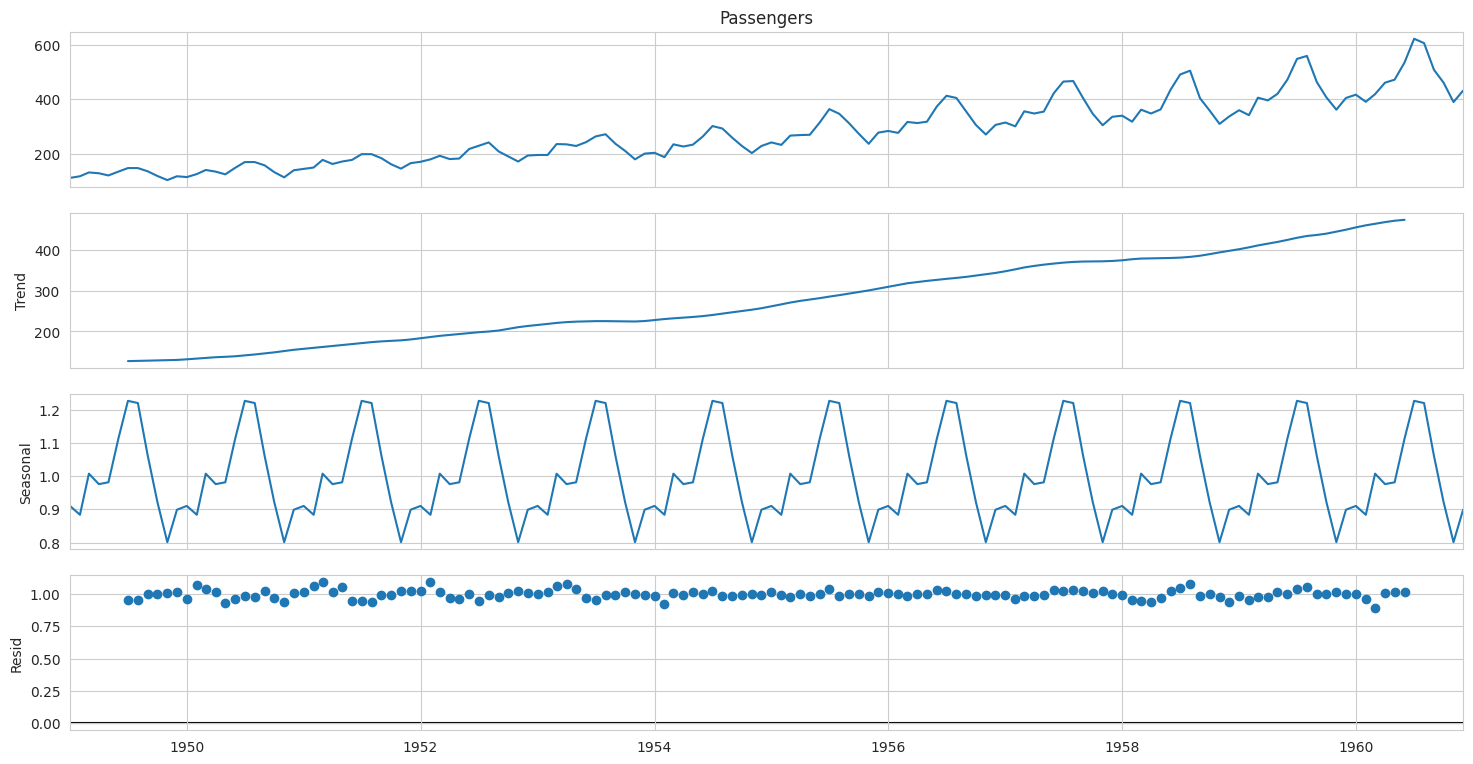

In [ ]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
decomposition=sm.tsa.seasonal_decompose(df['Passengers'],model='multiplicative')
fig=decomposition.plot()
fig.set_size_inches(15,8)
plt.show()

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


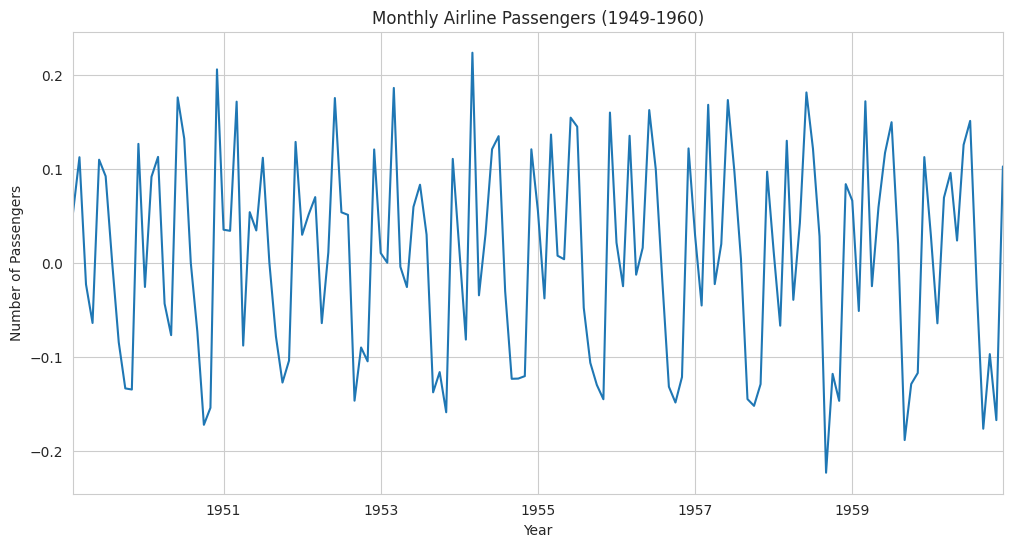

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
df_log=np.log(df['Passengers'])
df_diff=df_log.diff().dropna()
df_diff.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()
test_stationarity(df_diff)

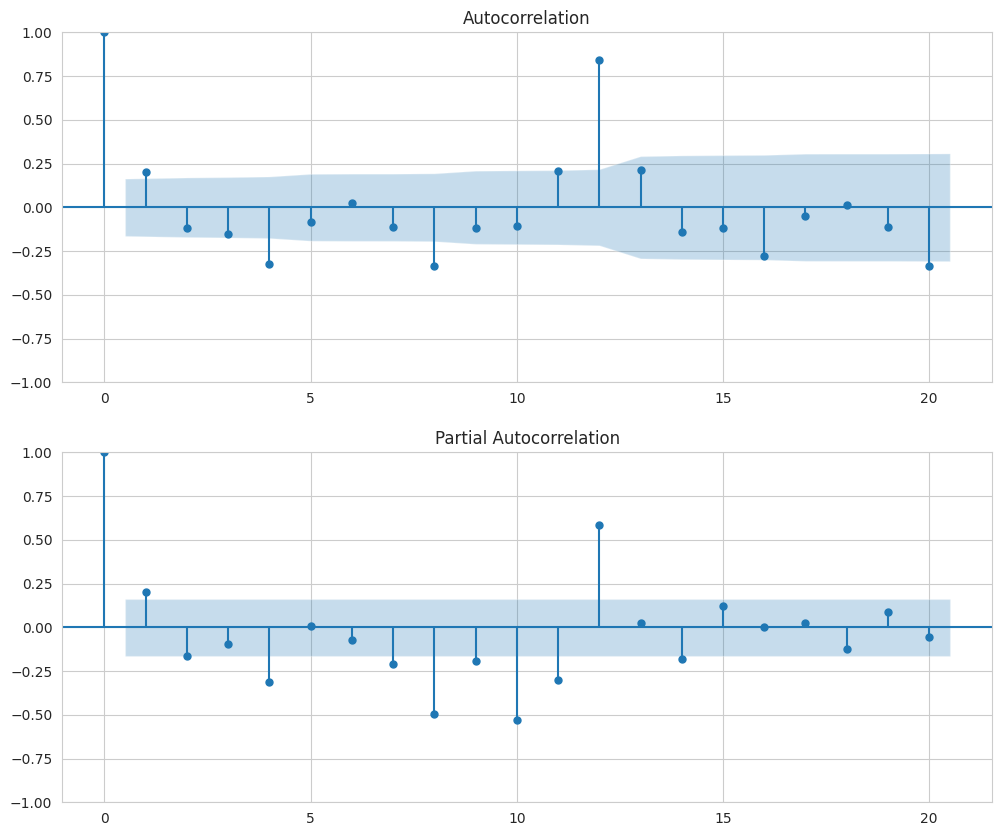

In [ ]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,10))
plot_acf(df_diff,ax=ax1,lags=20)
plot_pacf(df_diff,ax=ax2,lags=20)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


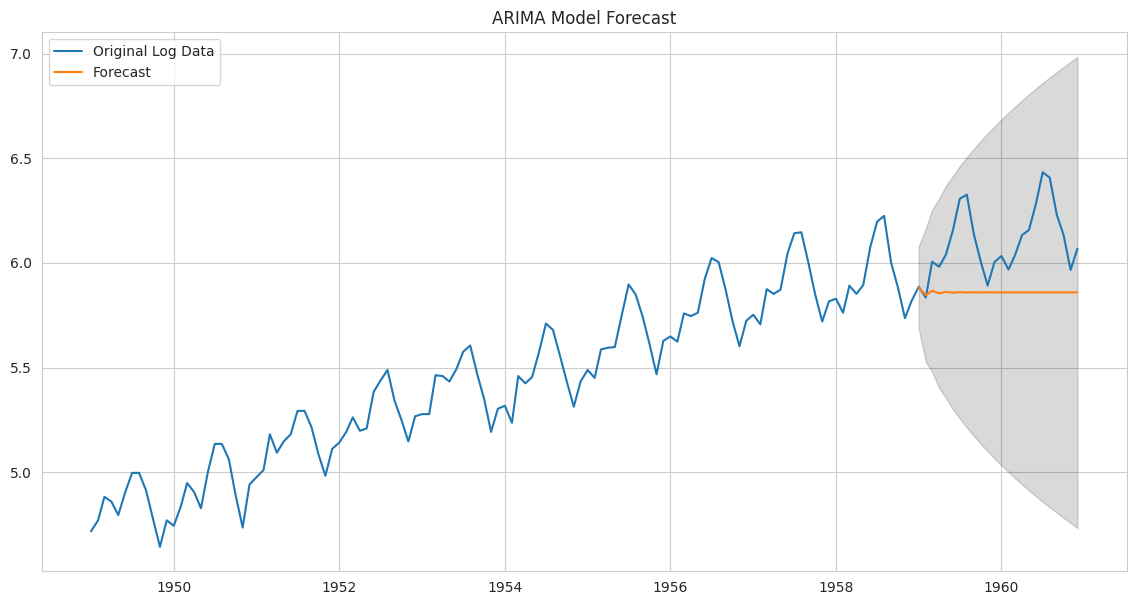

In [ ]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


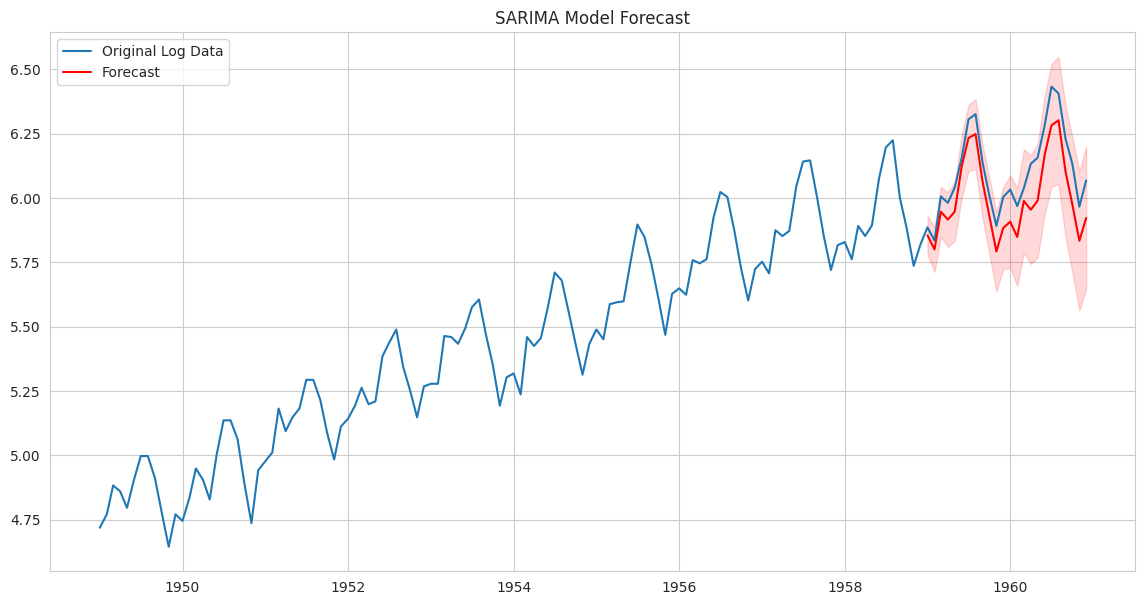

In [ ]:
sarima_model=sm.tsa.statespace.SARIMAX(train_data,order=(1,1,1),seasonal_order=(1,1,1,12),
                                       enforce_stationarity=False,enforce_invertibility=False,
                                       freq='MS')
sarima_result=sarima_model.fit()

sarima_forecast=sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci=sarima_forecast.conf_int()
plt.figure(figsize=(14,7))
plt.plot(df_log,label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean,label='Forecast',color='red')
plt.fill_between(sarima_forecast_ci.index,sarima_forecast_ci.iloc[:,0],sarima_forecast_ci.iloc[:,1],color='r',alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE:48.25


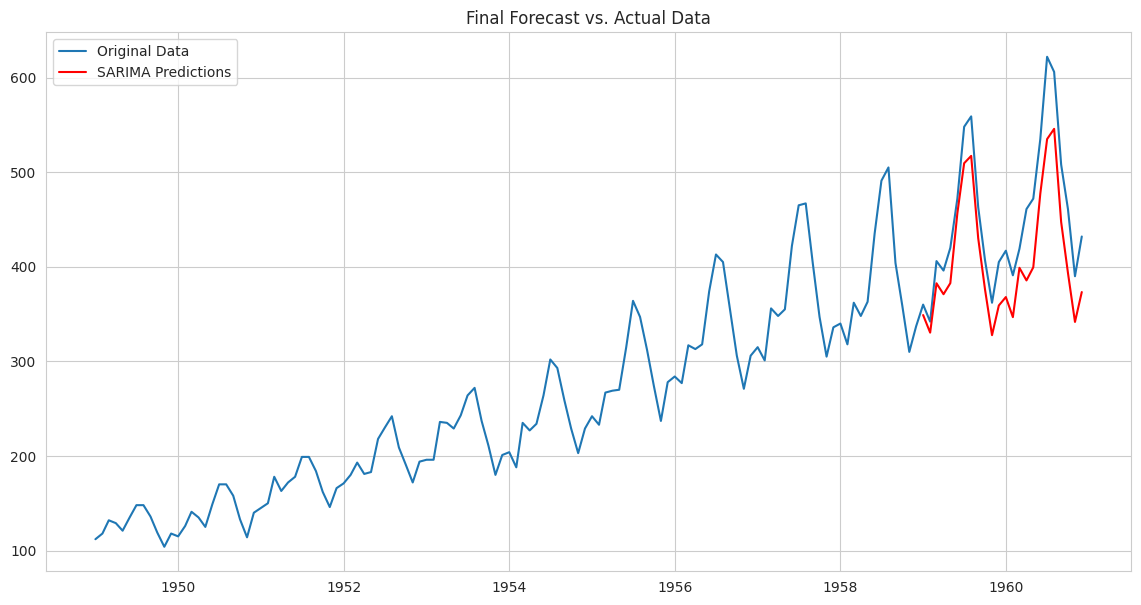

In [ ]:
original_test_data=np.exp(test_data)
sarima_predictions=np.exp(sarima_forecast.predicted_mean)
rmse=np.sqrt(mean_squared_error(original_test_data,sarima_predictions))
print(f"SARIMA Model RMSE:{rmse:.2f}")
plt.figure(figsize=(14,7))
plt.plot(df['Passengers'],label='Original Data')
plt.plot(sarima_predictions,label='SARIMA Predictions',color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()